# Notebook de teste da Random Forest para Daytrade

## 1️⃣ Imports e Configuração Inicial

In [19]:
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn


import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

## 2️⃣ Carregamento dos Dados

In [20]:
df = pd.read_csv('data/logs antigos/sar_sinais.csv', parse_dates=['data'])


df.head()

,data,ativo,direcao_sar,tendencia_ema,ema_ok,adx,adx_ok,status,motivo,open_resultado,close_resultado,resultado_teorico
0,2025-12-13 18:41:00,EURJPY-OTC,put,ALTA,False,19.51,False,NEGADO,EMA_CONTRA_TENDENCIA,181.003605,181.002765,WIN
1,2025-12-13 18:54:00,EURJPY-OTC,call,BAIXA,False,11.42,False,NEGADO,EMA_CONTRA_TENDENCIA,180.956705,180.957575,WIN
2,2025-12-13 18:56:00,EURJPY-OTC,put,BAIXA,True,12.90,False,NEGADO,ADX_FRACO,180.884735,180.885135,LOSS
3,2025-12-13 19:07:00,EURJPY-OTC,call,BAIXA,False,21.78,True,NEGADO,EMA_CONTRA_TENDENCIA,180.877535,180.878765,WIN
4,2025-12-13 19:19:00,EURJPY-OTC,put,ALTA,False,17.69,False,NEGADO,EMA_CONTRA_TENDENCIA,180.955505,180.953635,WIN


## 3️⃣ Limpeza e Seleção dos Dados

Posteriormente vamos treinar somente com sinais APROVADOS (o robô teria entrado neles).

In [21]:
# df = df[df['status'] == 'APROVADO'].copy()

Criamos o label binário:

In [22]:
df['y'] = (df['resultado_teorico'] == 'WIN').astype(int)

## 4️⃣ Engenharia de Features

Selecionamos apenas informações que estariam disponíveis no momento da decisão:

In [23]:
X = df[[
'adx',
'ema_ok',
'adx_ok'
]]


y = df['y']

In [24]:
# X = df[[
#     'direcao_sar'
#     'tendencia_ema',
#     'ema_ok',
#     'adx',
#     'adx_ok'
# ]]


# y = df['y']

Converter booleanos:

In [25]:
X['ema_ok'] = X['ema_ok'].astype(str).map({'True': 1, 'False': 0})
X['adx_ok'] = X['adx_ok'].astype(str).map({'True': 1, 'False': 0})

C:\Users\Jurandir\AppData\Local\Temp\ipykernel_5384\1126522709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ema_ok'] = X['ema_ok'].astype(str).map({'True': 1, 'False': 0})
C:\Users\Jurandir\AppData\Local\Temp\ipykernel_5384\1126522709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['adx_ok'] = X['adx_ok'].astype(str).map({'True': 1, 'False': 0})


## 5️⃣ Split Treino / Teste

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.3,
random_state=42,
stratify=y
)

## 6️⃣ Treinamento do Random Forest

In [27]:
model = RandomForestClassifier(
n_estimators=300,
max_depth=6,
min_samples_leaf=20,
random_state=42,
class_weight='balanced'
)


model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",20
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

## 7️⃣ Avaliação do Modelo

In [28]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

Relatório

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.45      0.55       184
           1       0.53      0.79      0.63       145

    accuracy                           0.60       329
   macro avg       0.63      0.62      0.59       329
weighted avg       0.64      0.60      0.59       329



Matriz de Confusão

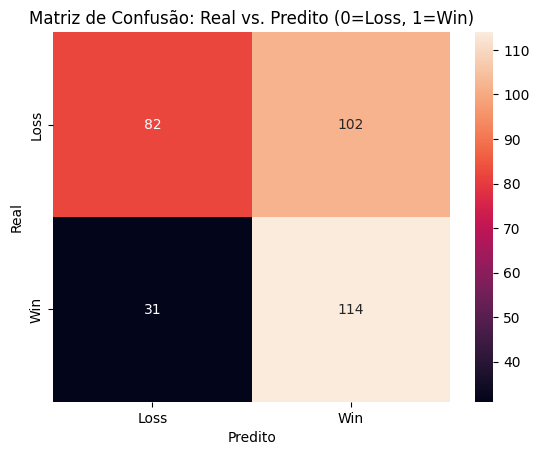

In [30]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão: Real vs. Predito (0=Loss, 1=Win)')
plt.show()

AUC ROC

In [31]:
roc_auc_score(y_test, y_prob)

0.6408170914542728

## 8️⃣ Importância das Features

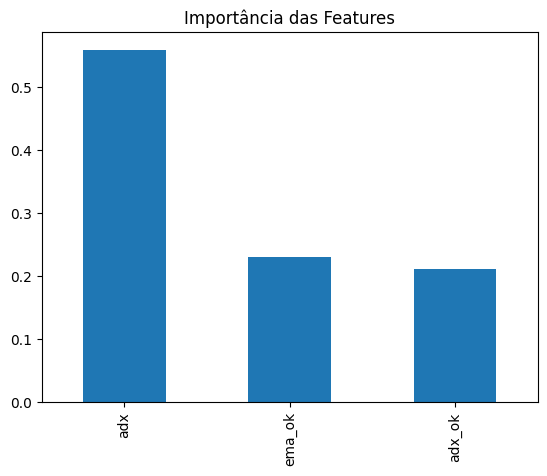

In [32]:
importances = pd.Series(
model.feature_importances_,
index=X.columns
).sort_values(ascending=False)


importances.plot(kind='bar', title='Importância das Features')
plt.show()

👉 Isso mostra o que realmente importa para o mercado, não o que achamos.

## 9️⃣ Simulação de Filtro Inteligente

Aceitar apenas sinais com probabilidade ≥ 60%:

In [33]:
df['prob_win'] = model.predict_proba(X)[:, 1]


filtro_ia = df[df['prob_win'] >= 0.6]


print('Trades antes:', len(df))
print('Trades após IA:', len(filtro_ia))
print('Win rate original:', df['y'].mean())
print('Win rate IA:', filtro_ia['y'].mean())

Trades antes: 1094
Trades após IA: 327
Win rate original: 0.4396709323583181
Win rate IA: 0.6330275229357798


## 🔟 Exportar o modelo

In [34]:
# Salva os arquivos
# joblib.dump(model, "rf_model.pkl")
# joblib.dump(scaler, "scaler.pkl")